In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import yaml

sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.preprocessing import StandardScaler
from preprocessing.sliding_window import create_windowed_dataset
from model.hierarchical_self_attention_model import HSA_model_session_guided_window

### Data loading

In [3]:
data_path = '../data/processed/usc-had.csv'
df = pd.read_csv(data_path)

In [4]:
df.head()

,subject,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,activity
0,11,0.788496,0.429586,0.158079,-9.520525,1.719961,-0.391400,2
1,11,0.795364,0.425966,0.176379,-8.312029,-0.693527,0.414264,2
2,11,0.819400,0.454920,0.205661,-5.492205,-3.495776,1.622760,2
3,11,0.815967,0.454920,0.212981,0.147443,-5.509936,0.817096,2
4,11,0.840003,0.454920,0.209321,3.772932,-9.135425,-0.794232,2


In [5]:
FEATURES = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
LABEL = 'activity'

In [6]:
df = df.fillna(0)
scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

In [7]:
hyperparameters = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)

metadata = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)['uschad_preprocess']

In [8]:
train_subject = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
val_subject = [12]
test_subject = [13, 14]

In [9]:
train_df = df.loc[df['subject'].isin(train_subject)]
val_df = df.loc[df['subject'].isin(val_subject)]
test_df = df.loc[df['subject'].isin(test_subject)]

SLIDING_WINDOW_LENGTH = metadata['sliding_win_len']
SLIDING_WINDOW_STEP = metadata['sliding_win_stride']
N_WINDOW, N_TIMESTEP = metadata['n_window'], metadata['n_timestep']

# FEATURES = metadata['feature_list']

X_train, y_train = create_windowed_dataset(
    train_df, FEATURES, LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_val, y_val = create_windowed_dataset(
    val_df, FEATURES, LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_test, y_test = create_windowed_dataset(
    test_df, FEATURES, LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

X_train = X_train.reshape(
    (X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_val = X_val.reshape(
    (X_val.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_test = X_test.reshape(
    (X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [10]:
print(X_train.shape)
print(y_train.shape)

(6462, 10, 100, 6)
(6462, 13)


In [11]:
y_train_mid = np.repeat(np.expand_dims(y_train, axis=1), repeats=metadata['n_window'], axis=1)
y_val_mid = np.repeat(np.expand_dims(y_val, axis=1), repeats=metadata['n_window'], axis=1)
y_test_mid = np.repeat(np.expand_dims(y_test, axis=1), repeats=metadata['n_window'], axis=1)

In [12]:
y_train_mid.shape

(6462, 10, 13)

In [13]:
hparam_file = open('../configs/hyperparameters.yaml', mode='r')
hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)
DATASET_NAME = 'uschad'
hparams_all = hyperparameters['HSA_model']
hparams = hparams_all[DATASET_NAME]

hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
hparams['n_outputs_window']=  y_train.shape[1]

## Training

In [14]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

6 Physical GPUs, 6 Logical GPUs


In [15]:
device_list = ['/gpu:'+str(i) for i in range(5, 6)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = HSA_model_session_guided_window(**hparams).get_compiled_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5',)
Number of devices: 1


In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 100, 6)] 0                                            
__________________________________________________________________________________________________
multi_window_encoder (MultiWind ((None, None, 128),  595200      input_1[0][0]                    
__________________________________________________________________________________________________
modality_encoder_block_1 (Modal (None, None, 128)    412800      multi_window_encoder[0][0]       
__________________________________________________________________________________________________
combined_sensor_self_attention_ ((None, 128), (None, 198016      modality_encoder_block_1[0][0]   
____________________________________________________________________________________________

In [17]:
checkpoint_filepath = "usc_checkpoints/cp-{epoch:04d}.ckpt"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               verbose=1)

In [ ]:
model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 64, epochs=45, validation_data=(X_val, [y_val_mid, y_val]), use_multiprocessing=True )

Epoch 1/45
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

In [ ]:
pred_mid, pred_sess = model.predict(X_test, batch_size=len(device_list) * 64)

In [ ]:
activity_map = { 1:'Walking Forward', 2:'Walking Left',  3:'Walking Right',
                4:'Walking Upstairs', 5:'Walking Downstairs', 6:'Running Forward',
                7:'Jumping Up', 8:'Sitting', 9:'Standing', 10: 'Sleeping',
                11:'Elevator Up', 12:'Elevator Down'}
activity_list = list(activity_map.values())

In [ ]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), labels=list(activity_map.keys()), target_names=activity_list))

In [26]:
# activity_map

<AxesSubplot:>

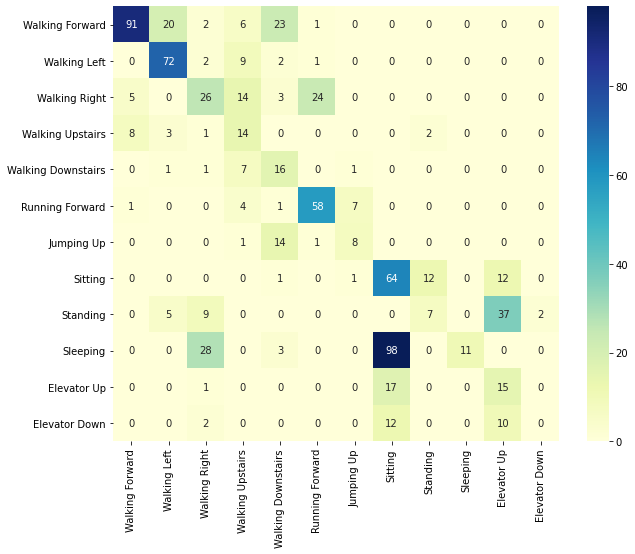

In [27]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [28]:
y_test_mid.shape

(797, 10, 13)

In [29]:
pred_mid.shape

(797, 10, 13)

In [30]:
print(classification_report(np.argmax(y_test_mid.reshape(-1, 13), axis=1), np.argmax(pred_mid.reshape(-1, 13), axis=1), labels=list(activity_map.keys()), target_names=activity_list))

                    precision    recall  f1-score   support

   Walking Forward       0.90      0.63      0.74      1430
      Walking Left       0.72      0.82      0.77       860
     Walking Right       0.56      0.36      0.44       720
  Walking Upstairs       0.26      0.51      0.34       280
Walking Downstairs       0.27      0.64      0.38       260
   Running Forward       0.64      0.89      0.74       710
        Jumping Up       0.56      0.21      0.30       240
           Sitting       0.30      0.72      0.43       900
          Standing       0.27      0.09      0.13       600
          Sleeping       1.00      0.08      0.15      1400
       Elevator Up       0.11      0.02      0.04       330
     Elevator Down       0.13      0.41      0.20       240

          accuracy                           0.47      7970
         macro avg       0.48      0.45      0.39      7970
      weighted avg       0.62      0.47      0.45      7970



<AxesSubplot:>

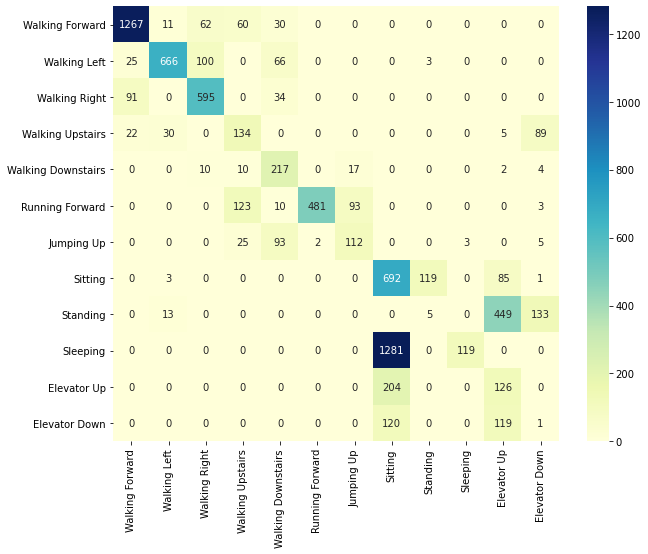

In [28]:
confm = confusion_matrix(np.argmax(y_test_mid.reshape(-1, 13), axis=1), np.argmax(pred_mid.reshape(-1, 13), axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")